Jon V

May 7, 2018

In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from KRR_reproduce import *
from generate_H2_data import *
from scipy.interpolate import interp1d

In [2]:
from __future__ import division
import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

# Read in dataset.

In [3]:
# read in calculation data (computed elsewhere)
str_pref = '/Users/jonpvandermause/Desktop/store/'

# read in the calculation data
sim_no = 150
ens = []
seps= []
fours = []

min_en = 0
eq_sep = 0

for n in range(sim_no):
    # load separation, energy, and density
    sep = np.load(str_pref+'sep_store/sep'+str(n)+'.npy')
    en = np.load(str_pref+'en_store/en'+str(n)+'.npy')
    four = np.load(str_pref+'four_store/four'+str(n)+'.npy')

    # put results in a nicer format
    sep = np.reshape(sep,(1,))[0]
    en = np.reshape(en,(1,))[0]['energy']
    four = np.real(four)
    
    # get min energy and equilibrium separation
    if en < min_en:
        min_en = en
        eq_sep = sep

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

print('The minimum energy is '+str(min_en)+' eV. The equilibrium separation is '+str(eq_sep)+' Angstrom.')

The minimum energy is -31.74695245487133 eV. The equilibrium separation is 0.7483221476510067 Angstrom.


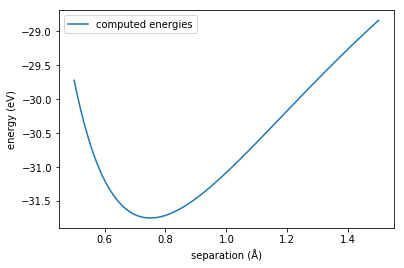

In [4]:
# create figure
figure = plt.figure()
ax = figure.add_subplot(1,1,1)

# add computed energies
ax.plot(seps, ens, label='computed energies')

ax.set_xlabel('separation (Å)')
ax.set_ylabel('energy (eV)')
ax.legend()
plt.show()

# Define helper functions.

In [5]:
kcal_conv = 0.043

In [6]:
def get_train_test(M, N):
    # define training and test indices
    train_indices = [int(n) for n in np.round(np.linspace(0,N-1,M))]
    test_indices = [n for n in range(N) if n not in train_indices]

    # define train and test sets
    train_set = np.reshape(np.array([seps[n] for n in train_indices]),(M,1))
    test_set = np.reshape(np.array([seps[n] for n in test_indices]),(N-M,1))

    train_ens = np.reshape(np.array([ens[n] for n in train_indices]),(M,1))
    test_ens = np.reshape(np.array([ens[n] for n in test_indices]),(N-M,1))

    train_fours = np.array([fours[n] for n in train_indices])
    test_fours = np.array([fours[n] for n in test_indices])
    
    return  train_set, test_set, train_ens, test_ens, train_fours, test_fours

In [7]:
def fit_krr(train_X, train_Y, test_X, test_Y, alphas, gammas, cv):
    # define model
    kr = GridSearchCV(KernelRidge(kernel='rbf'), cv=cv,
                      param_grid={"alpha": alphas,
                                  "gamma": gammas})
    
    # fit model
    kr.fit(train_X, train_Y)
    
    # predict test energies
    y_kr = kr.predict(test_X)
    
    # calculate MAE and max error
    errs = np.abs(test_Y-y_kr)
    MAE = np.mean(np.abs(test_Y-y_kr))
    max_err = np.max(np.abs(test_Y-y_kr))
    
    return kr, y_kr, errs, MAE, max_err

In [8]:
def fit_quick(train_X, train_Y, alpha, gamma):
    kr = KernelRidge(kernel='rbf',alpha = alpha, gamma = gamma)
    kr.fit(train_X, train_Y)
    return kr

In [9]:
def fit_KS(train_set, train_ens, test_set, test_ens, alphas, gammas, cv, seps):
    [kr, y_kr, errs, MAE, max_err] = fit_krr(train_set, \
                                         train_ens, test_set, test_ens, \
                                         alphas, gammas, cv)
    
    # check MAE in kcal/mol
    print(kr.best_estimator_)

    # plot predictions
    plt.figure()
    plt.plot(train_set, train_ens, 'x')
    plt.plot(seps, ens, 'b')
    plt.plot(test_set, y_kr,'r')
    plt.show()

    # plot error
    fig, ax = plt.subplots(1,1)
    ax.plot(test_set, errs,label='KS')
    ax.set_xlabel('separation (Å)')
    ax.set_ylabel('log error')
    ax.set_yscale('log')
    plt.legend()
    plt.show()
    
    return kr, y_kr, errs, MAE, max_err

In [10]:
def fit_KS_pot(train_set, train_ens, test_set, test_ens, alphas, gammas, cv, seps):
    [kr, y_kr, errs, MAE, max_err] = fit_krr(train_set, \
                                         train_ens, test_set, test_ens, \
                                         alphas, gammas, cv)
    
    # check MAE in kcal/mol
    print(kr.best_estimator_)
    
    return kr, y_kr, errs, MAE, max_err

In [11]:
def spline_test(train_set, train_ens, test_set, test_ens):
    f = interp1d(train_set.reshape(len(train_set),), \
                  train_ens.reshape(len(train_ens),), kind='cubic')
    
    err = np.mean(np.abs(f(test_set)-test_ens))
    
    return err

In [12]:
def get_potentials(train_set, M, grid_len = 5.29177*2):
    # get potential kernel
    pots = []
    for n in range(M):
        dist = train_set[n]
        pot = pot_rep(dist, grid_len)
        pots.append(pot) 
        
    pots = np.array(pots)
    pots = np.reshape(pots,(M, pots.shape[1]**3))
    
    return pots

In [13]:
def pos_to_four(train_set, train_fours, M, alpha, gamma):
    # build position to Fourier models
    krs = []
    no_four = 25
    train_X = np.reshape(train_set, (M,1))

    alpha = 1e-10
    gamma = 1

    for i in range(no_four):
        four1 = i
        for j in range(no_four):
            four2 = j
            for k in range(no_four):
                four3 = k
                
                # build model
                train_Y = np.reshape(train_fours[:,four1, four2, four3],(M,1))
                kr = fit_quick(train_X, train_Y, alpha, gamma)

                krs.append(kr)    
    return krs

In [22]:
def four_to_en(train_fours, train_ens, M, N, seps):
    # build Fourier to energy model
    train_X = np.reshape(train_fours,(M,25**3))
    test_X = np.reshape(test_fours,(N-M,25**3))
    train_Y = train_ens

    alphas = np.logspace(-20, -1, 6)
    gammas = np.logspace(-9, -7, 100)
    
    if M < 10:
        cv = M - 1
    else:
        cv = 9

    [FE_kr, y_kr, errs, MAE, max_err] = fit_krr(train_X, \
                                             train_Y, test_X, test_ens, \
                                             alphas, gammas, cv)
    
    return FE_kr, y_kr, errs, MAE, max_err

In [23]:
def doub_map(test_set, test_ens, krs, FE_kr, M, N):
    # perform double mapping
    no_four = 25
    HK_errs = []

    # predict the density
    print('progress:')
    for n in range(N-M):
        sep = test_set[n][0]

        # get density
        test_dens = np.zeros([no_four, no_four, no_four])
        count = 0
        for i in range(no_four):
            for j in range(no_four):
                for k in range(no_four):
                    # use model to calculate density
                    kr_curr = krs[count]
                    test_dens[i,j,k]=kr_curr.predict(sep)[0][0]

                    count+=1

        # get energy
        true_en = test_ens[n][0]
        test_en = FE_kr.predict(np.reshape(test_dens,(1,25**3)))[0][0]
        HK_err = true_en-test_en
        HK_errs.append(HK_err)
        
        print(n)

    HK_errs = np.array(HK_errs)
    MAE = np.mean(np.abs(HK_errs))
    max_err = np.max(np.abs(HK_errs))
    
    return HK_errs, MAE, max_err

In [24]:
def doub_map_fast(test_set, test_ens, krs, FE_kr, M, N):
    # perform double mapping
    no_four = 25

    # get density
    test_dens = np.zeros([N-M, no_four, no_four, no_four])
    count = 0
    for i in range(no_four):
        for j in range(no_four):
            for k in range(no_four):
                # use model to calculate density
                kr_curr = krs[count]
                test_dens[:,i,j,k]=kr_curr.predict(test_set).reshape(-1,)

                count+=1

    # get energy
    pred_ens = FE_kr.predict(np.reshape(test_dens,(N-M,25**3)))
    HK_errs = test_ens-pred_ens
    MAE = np.mean(np.abs(HK_errs))
    max_err = np.max(np.abs(HK_errs))
    
    return HK_errs, MAE, max_err

# KS model: position to energy

In [17]:
import warnings
warnings.filterwarnings("ignore")


 Current training set size: 5
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=1.0, kernel='rbf',
      kernel_params=None)


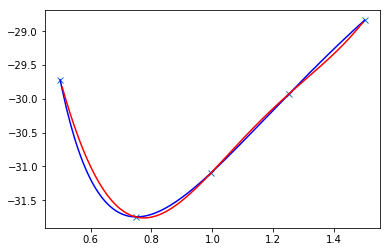

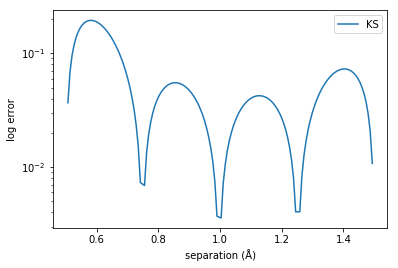

The KRR max error in kcal/mol is 4.522669778460852
The KRR MAE in kcal/mol is 1.3471636471512427
The cubic spline MAE in kcal/mol is 0.8513469259552956

 Current training set size: 7
KernelRidge(alpha=2.511886431509572e-09, coef0=1, degree=3,
      gamma=2.3636363636363638, kernel='rbf', kernel_params=None)


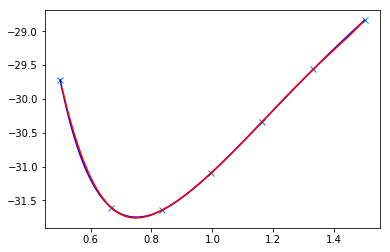

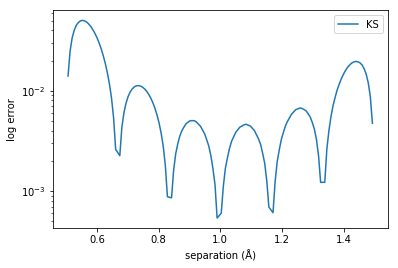

The KRR max error in kcal/mol is 1.1715855836016473
The KRR MAE in kcal/mol is 0.24092209733787764
The cubic spline MAE in kcal/mol is 0.2165490442634205

 Current training set size: 10
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=4.090909090909091,
      kernel='rbf', kernel_params=None)


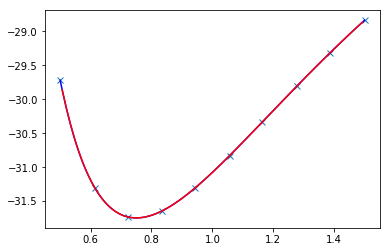

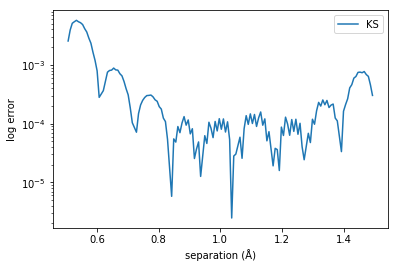

The KRR max error in kcal/mol is 0.13309869676613004
The KRR MAE in kcal/mol is 0.013628860108325544
The cubic spline MAE in kcal/mol is 0.044370575100204965

 Current training set size: 50
KernelRidge(alpha=3.981071705534969e-13, coef0=1, degree=3,
      gamma=6.363636363636364, kernel='rbf', kernel_params=None)


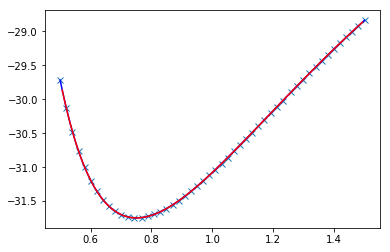

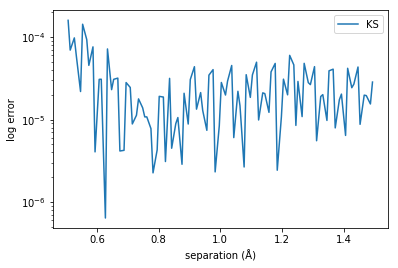

The KRR max error in kcal/mol is 0.003718679036804921
The KRR MAE in kcal/mol is 0.0006320676219085864
The cubic spline MAE in kcal/mol is 0.0009326262117558349

 Current training set size: 100
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=2.7272727272727275,
      kernel='rbf', kernel_params=None)


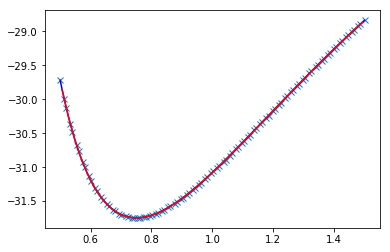

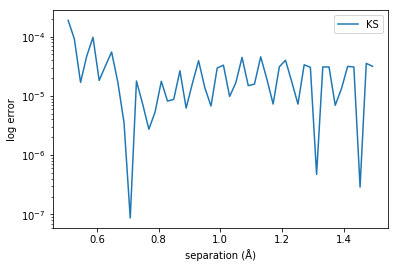

The KRR max error in kcal/mol is 0.004372943974804558
The KRR MAE in kcal/mol is 0.0006275516636849869
The cubic spline MAE in kcal/mol is 0.0013558892644292154


In [47]:
# choose training set sizes
N = 150
Ms = [5, 7, 10, 50, 100]

# choose hyperparameter grids
alphas = np.logspace(-20, -1, 6)
gammas = np.linspace(1, 10, 100)

for n in range(len(Ms)):
    M = Ms[n]  
    
    # split into test and training
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N)
    
    if M < 10:
        cv = M-1
    else:
        cv = 9

    # fit the model and make plots
    print('\n Current training set size: '+str(M))
    
    [kr, y_kr, errs, MAE, max_err] = fit_KS(train_set, train_ens, \
                                            test_set, test_ens, alphas, \
                                            gammas, cv, seps)
    
    # do spline test for comparison (what does KRR bring to the table?)
    err = spline_test(train_set, train_ens, test_set, test_ens)
    
    print('The KRR max error in kcal/mol is '+str(max_err / kcal_conv))
    print('The KRR MAE in kcal/mol is '+str(MAE / kcal_conv))
    print('The cubic spline MAE in kcal/mol is '+str(err/kcal_conv))

# KR model: potential

In [82]:
# choose training set sizes
N = 150
Ms = [5, 7, 10, 50, 100]

# choose hyperparameter grids
alphas = np.logspace(-20, -1, 1)
gammas = np.logspace(-4, -1, 100)

for n in range(len(Ms)):
    M = Ms[n]
    
    # split into test and training
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N)
    
    # get potential representations
    train_pots = get_potentials(train_set, M, 4)
    test_pots = get_potentials(test_set, N-M, 4)
    
    # choose k
    if M < 10:
        cv = M-1
    else:
        cv = 9

    # fit the model and make plots
    print('\n Current training set size: '+str(M))
    
    [kr, y_kr, errs, MAE, max_err] = fit_KS_pot(train_pots, train_ens, \
                                            test_pots, test_ens, alphas, \
                                            gammas, cv, seps)
    
    # do spline test for comparison (what does KRR bring to the table?)
    err = spline_test(train_set, train_ens, test_set, test_ens)
    
    print('The KRR max error in kcal/mol is '+str(max_err / kcal_conv))
    print('The KRR MAE in kcal/mol is '+str(MAE / kcal_conv))
    print('The cubic spline MAE in kcal/mol is '+str(err/kcal_conv))


 Current training set size: 5
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=0.0007054802310718645,
      kernel='rbf', kernel_params=None)
The KRR max error in kcal/mol is 5.7526809232119085
The KRR MAE in kcal/mol is 1.5208213204124004
The cubic spline MAE in kcal/mol is 0.8513469259552956

 Current training set size: 7
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=0.001873817422860383,
      kernel='rbf', kernel_params=None)
The KRR max error in kcal/mol is 1.720394697115581
The KRR MAE in kcal/mol is 0.31345991873772966
The cubic spline MAE in kcal/mol is 0.2165490442634205

 Current training set size: 10
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=0.003511191734215131,
      kernel='rbf', kernel_params=None)
The KRR max error in kcal/mol is 0.32195953851539855
The KRR MAE in kcal/mol is 0.031085359160264198
The cubic spline MAE in kcal/mol is 0.044370575100204965

 Current training set size: 50
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=0.0015199110829529332,


The potential maps do worse, so we'll focus on position moving forward (which is much faster to train)

# HK model: position (systematic)

In [25]:
Ms = [5, 7, 10, 50, 100]
N = 150

for n in range(len(Ms)):
    # choose train size
    M = Ms[n]

    print('\n \n current training set size = '+str(M))

    # split into test and training
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N)

    # fit position to fourier models (i.e. create 15k+ KRR models)
    alpha = 1e-10
    gamma = 1
    krs = pos_to_four(train_set, train_fours, M, alpha, gamma)

    # fit fourier to energy model
    [FE_kr, y_kr, errs, MAE, max_err] = four_to_en(train_fours, train_ens, M, N, seps)

    print('\n Fourier to energy model:')
    print(FE_kr.best_estimator_)
    print('MAE='+str(MAE/kcal_conv))
    print('max error='+str(max_err/kcal_conv))

    # perform double mapping
    [HK_errs, MAE, max_err] = doub_map_fast(test_set, test_ens, krs, FE_kr, M, N)

    print('\n Double mapping:')
    print('MAE='+str(MAE / kcal_conv))
    print('max error='+str(max_err/kcal_conv))


 
 current training set size = 5

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=2.3644894126454072e-08,
      kernel='rbf', kernel_params=None)
MAE=0.7110628924335836
max error=3.0806373528550797

 Double mapping:
MAE=0.7839829244003399
max error=3.6099727694437402

 
 current training set size = 7

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=5.2140082879996844e-08,
      kernel='rbf', kernel_params=None)
MAE=0.09772249529236092
max error=0.6429523348777176

 Double mapping:
MAE=0.10075301904311379
max error=0.6650685892926573

 
 current training set size = 10

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=7.924828983539185e-08,
      kernel='rbf', kernel_params=None)
MAE=0.006172502538930853
max error=0.0695345665527585

 Double mapping:
MAE=0.005836141242646964
max error=0.0650518930608224

 
 current training set size = 50

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=